In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.constraints import MinMaxNorm, MaxNorm
from keras.regularizers import l2,l1
from keras.callbacks import EarlyStopping

from scipy.stats.stats import pearsonr

<ipython-input-1-2fcb0107e970>:18: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# df8 = pd.read_csv("8dec.csv")
# df17 = pd.read_csv("17dec.csv")
# df817 = pd.read_csv("8dec17dec.csv")
# df321 = pd.read_csv("3dec21dec.csv")

df8 = pd.read_csv("8dec - Sheet1.csv")
df17 = pd.read_csv("17dec - Sheet1.csv")
df817 = pd.read_csv("8dec17dec - Sheet1.csv")
df321 = pd.read_csv("3dec21dec - Sheet1.csv")

from pathlib import Path
image_dir= Path("/content/gdrive/MyDrive/AYUSHH/Xtest8dec17dec")
# image_dir= Path("Xtest8dec17dec")
filepaths_1 = pd.Series(list(image_dir.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_1 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_1]
sorted_filepaths_1 = [x for _, x in sorted(zip(numeric_parts_1, filepaths_1))]
filepaths_series_1 = pd.Series(sorted_filepaths_1, name='Filepath')
bmass_1 = df817['Biomass']
test_img =  pd.concat([filepaths_series_1,bmass_1],axis=1)

image_dir_3= Path("/content/gdrive/MyDrive/AYUSHH/Xtrain3dec21dec")
# image_dir_3= Path("Xtrain3dec21dec")
filepaths_3 = pd.Series(list(image_dir_3.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_3 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_3]
sorted_filepaths_3 = [x for _, x in sorted(zip(numeric_parts_3, filepaths_3))]
filepaths_series_3 = pd.Series(sorted_filepaths_3, name='Filepath')
bmass_3 = df321['Biomass']
train_img = pd.concat([filepaths_series_3,bmass_3],axis=1)

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_img['Biomass'] = scaler.fit_transform(train_img['Biomass'].values.reshape(-1, 1))  # leanrt u and sigma for train data

In [ ]:
train_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator( # data_gen object -- in parameters ke according iamge par operation
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_data = train_generator_aug.flow_from_dataframe(      #6D --- (5D,2D) tensor ( #batches and other 4)
    dataframe=train_img,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512), # why use this?
    color_mode='rgb',
    class_mode='raw',
    batch_size=4,   # small batch size -- noisier gradient descent
    shuffle=True,
    seed=42,
    subset='training'
)
# X_train, y_train = next(train_data)   # batch data
# X_train2,y_train2= train_images       # too much data to unpack

val_data = train_generator_aug.flow_from_dataframe(
    dataframe=train_img,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='raw',
    batch_size=4,
    shuffle=True,
    seed=42,
    subset='validation'
)
# X_val, y_val = next(val_images)

test_data = test_generator_aug.flow_from_dataframe(
    dataframe=test_img,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='raw',
    batch_size=2,
    shuffle=False
)
# X_test, y_test = next(test_images)
# X_test shape is 2,512,512,3
# y_test shape is (2,)

**ADDED 2 DENSE LAYERS**

dropout = 0.3

In [ ]:
import tensorflow as tf
from keras.applications import VGG16

# Load VGG16 model without top (fully connected layers)
base_model = VGG16(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom regression head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])

# Print model summary
model.summary()

In [ ]:
import time
t0=time.time()
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=90,
    verbose=1,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=5,
    #         restore_best_weights=True
    #     )
    # ]
)
print("Training time:", time.time()-t0)  # look at the last line

history.history.keys()

# plot history
# summarize history for loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("epoches")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
model_path = '/content/gdrive/MyDrive/AYUSHH/vgg16part2.h5'
# Save the entire model (architecture and weights)
model.save(model_path)
print("Model saved successfully.")

Model saved successfully.


In [ ]:
#predicting scores of the val set loss(mse) metric(mae) metric(rmse) 3dec21dec 20 % r s=42
scoresval = model.evaluate(val_data, verbose=0)
print("val mse(loss)    val_mae     val_rmse")
print(scoresval)

val mse(loss)    val_mae     val_rmse
[0.012789499014616013, 0.09554843604564667, 0.11309066414833069]


In [ ]:
Pred= model.predict(test_data)
pred_testunscaled = scaler.inverse_transform(Pred)
y_test_all = test_img['Biomass'].values.reshape(-1, 1)

54/54 [==============================] - 94s 2s/step


In [ ]:
lm = LinearRegression()
lm.fit(y_test_all,pred_testunscaled)

LinearRegression()

Test dataset prediction - 8dec
euqation of line is : y=[0.63769292]*x + [179.82476096]
r2 score= 0.761
mae=124.698
mse=23,667.893
rmse=153.844


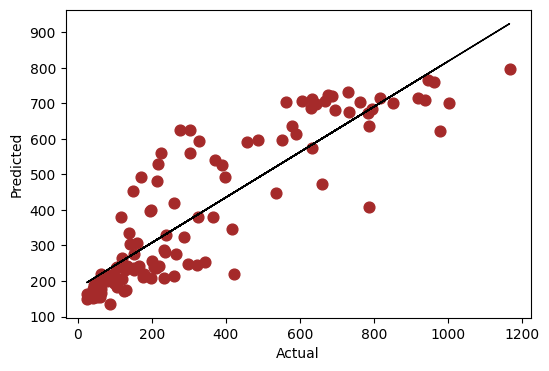

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_test_all,pred_testunscaled,color='brown',s=60)
ax.plot(y_test_all,lm.predict(y_test_all), color='black', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
print("Test dataset prediction - 8dec")

print("euqation of line is : y="+str(lm.coef_[0])+"*x + "+str(lm.intercept_))

print("r2 score= {:,.3f}".format(lm.score(y_test_all,pred_testunscaled)))
print("mae={:,.3f}".format(metrics.mean_absolute_error(y_test_all,pred_testunscaled)))
print("mse={:,.3f}".format(metrics.mean_squared_error(y_test_all,pred_testunscaled)))
print("rmse={:,.3f}".format(np.sqrt(metrics.mean_squared_error(y_test_all,pred_testunscaled))))

In [ ]:
#overegularisation
#values in a straight line
#undreprediction at large values
# without augmentation
# more image data
# access to server

In [ ]:
import tensorflow as tf
from keras.applications import VGG16

# Load VGG16 model without top (fully connected layers)
base_model = VGG16(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom regression head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])

# Print model summary
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                              

In [ ]:
model.weights

Epoch 1/150
22/22 [==============================] - 33s 885ms/step - loss: 1.3121 - mae: 0.9251 - root_mean_squared_error: 1.1454 - val_loss: 0.1421 - val_mae: 0.3396 - val_root_mean_squared_error: 0.3770
Epoch 2/150
22/22 [==============================] - 9s 409ms/step - loss: 0.5777 - mae: 0.5842 - root_mean_squared_error: 0.7601 - val_loss: 0.2197 - val_mae: 0.4427 - val_root_mean_squared_error: 0.4687
Epoch 3/150
22/22 [==============================] - 11s 485ms/step - loss: 0.6130 - mae: 0.6223 - root_mean_squared_error: 0.7830 - val_loss: 0.1816 - val_mae: 0.4003 - val_root_mean_squared_error: 0.4261
Epoch 4/150
22/22 [==============================] - 11s 481ms/step - loss: 0.4434 - mae: 0.5356 - root_mean_squared_error: 0.6659 - val_loss: 0.1316 - val_mae: 0.3335 - val_root_mean_squared_error: 0.3628
Epoch 5/150
22/22 [==============================] - 10s 452ms/step - loss: 0.4109 - mae: 0.5181 - root_mean_squared_error: 0.6410 - val_loss: 0.0694 - val_mae: 0.2375 - val_roo

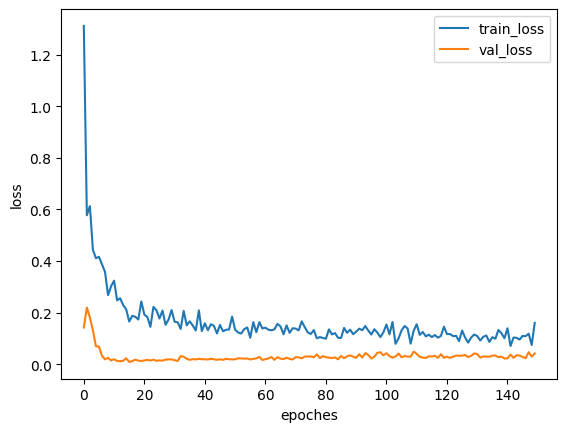

In [ ]:
import time
t0=time.time()
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=150,
    verbose=1,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=5,
    #         restore_best_weights=True
    #     )
    # ]
)
print("Training time:", time.time()-t0)  # look at the last line

history.history.keys()

# plot history
# summarize history for loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("epoches")
plt.ylabel("loss")
plt.legend()
plt.show()

**KINDLY MAKE REQUIRED CHANGES IN PATH**




In [ ]:
model_path = '/content/gdrive/MyDrive/AYUSHH/vgg16.h5'
# Save the entire model (architecture and weights)
model.save(model_path)
print("Model saved successfully.")

Model saved successfully.


In [ ]:
#predicting scores of the val set loss(mse) metric(mae) metric(rmse) 3dec21dec 20 % r s=42
scoresval = model.evaluate(val_data, verbose=0)
print("val mse(loss)    val_mae     val_rmse")
print(scoresval)

val mse(loss)    val_mae     val_rmse
[0.03802090138196945, 0.1728307604789734, 0.19498948752880096]


In [ ]:
Pred= model.predict(test_data)
pred_testunscaled = scaler.inverse_transform(Pred)
y_test_all = test_img['Biomass'].values.reshape(-1, 1)

54/54 [==============================] - 94s 2s/step


In [ ]:
sbfbs

inverse scaling, flow_from_directory , output copy -- send her organised file

In [ ]:
lm = LinearRegression()
lm.fit(y_test_all,pred_testunscaled)

LinearRegression()

Test dataset prediction - 8dec
euqation of line is : y=[0.54242078]*x + [193.60506113]
r2 score= 0.786
mae=126.568
mse=24,417.469
rmse=156.261


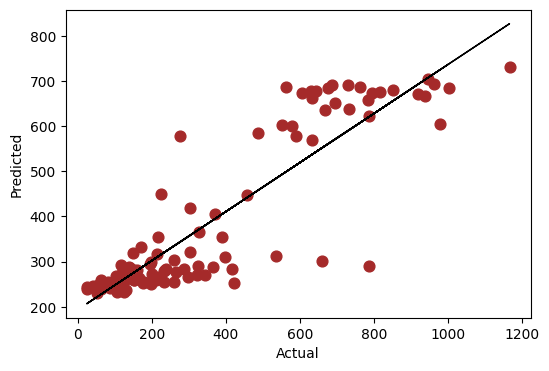

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_test_all,pred_testunscaled,color='brown',s=60)
ax.plot(y_test_all,lm.predict(y_test_all), color='black', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
print("Test dataset prediction - 8dec")

print("euqation of line is : y="+str(lm.coef_[0])+"*x + "+str(lm.intercept_))

print("r2 score= {:,.3f}".format(lm.score(y_test_all,pred_testunscaled)))
print("mae={:,.3f}".format(metrics.mean_absolute_error(y_test_all,pred_testunscaled)))
print("mse={:,.3f}".format(metrics.mean_squared_error(y_test_all,pred_testunscaled)))
print("rmse={:,.3f}".format(np.sqrt(metrics.mean_squared_error(y_test_all,pred_testunscaled))))